In [1]:
'''This block links the notebook to other folders.'''

import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- 2. Define Absolute Path for figs folder ---
figs_dir = os.path.join(project_root, 'figs')
data_dir = os.path.join(project_root, 'generated_data')

# Create the directory if it doesn't exist (good practice!)
os.makedirs(figs_dir, exist_ok=True) 

In [2]:
from src import Halos, SimSlab, BiasModel, ThetaModel, ModelComparison, SimCube
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from mpmath import gammainc
from mpmath import erf
import plothist

In [3]:
halo_data = fits.open("/Users/elyasfarah/Documents/Galaxy Bias/halos.fits")
halo_data = pd.DataFrame(halo_data[1].data)
halo_data.columns

Index(['ix', 'iy', 'iz', 'x', 'y', 'z', 'mass'], dtype='object')

In [4]:
delta_m = fits.open("/Users/elyasfarah/Documents/Galaxy Bias/deltam.fits")
delta_m = pd.DataFrame(delta_m[1].data)
delta_m.columns

Index(['ix', 'iy', 'iz', 'dens'], dtype='object')

In [5]:
# extracting each of the halos and matter corrdinates

x_halo = halo_data["x"].values
y_halo = halo_data["y"].values
z_halo = halo_data["z"].values
M_halo = halo_data["mass"].values



ix_matter = delta_m["ix"]
iy_matter = delta_m["iy"]
iz_matter = delta_m["iz"]
dens = delta_m["dens"]
# halo_pos = np.array([x_halo, y_halo, z_halo]).T
# matter_pos = np.array([ix_matter, iy_matter, iz_matter]).T #given to the object

del delta_m, halo_data

In [6]:
M_min = 10**12

M_max = 10**13
M_range = '12_13'
M_halo_bin_edges = np.logspace(np.log10(M_min), np.log10(M_max), 6)

In [7]:
# calculating the bins centers
M_halo_bin_center = (M_halo_bin_edges[1:] + M_halo_bin_edges[:-1])/2 # this need to change

In [8]:
delta_m_grid = SimSlab.delta_m_catalogue_to_grid(ix_matter= ix_matter, iy_matter=iy_matter, 
                                              iz_matter=iz_matter, delta_m=dens, resol=256)

In [9]:
halo_grid_bin = SimSlab.halo_catalog_to_grid(x_halo=x_halo, y_halo=y_halo, 
                                            z_halo=z_halo, l_cube=1000, resol=256)

the length of one voxel 3.90625 Mpc/h


In [10]:
slabs_array = []
for j in range(8):
    sim_slab = SimSlab(delta_m_3D=delta_m_grid, N_halos_3D=halo_grid_bin, N_slabs=8, rank = j, direction="z", L = 1000, ncells=4096)
    slabs_array.append(sim_slab)
stacked_slabs = SimSlab.from_slabs(slabs_array = slabs_array, L = 1000)

the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h


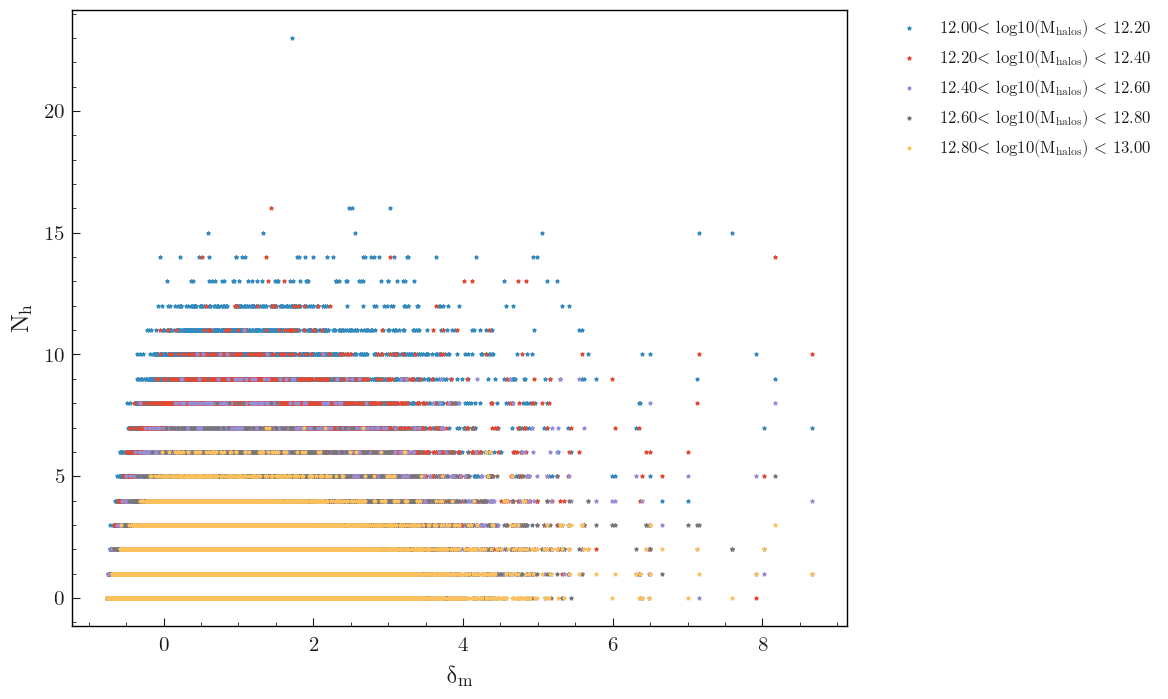

In [11]:
fig_and_ax = plt.subplots(figsize = (10, 8))
binned_slabs = []
for i, (M_min, M_max) in enumerate(zip(M_halo_bin_edges[:-1], M_halo_bin_edges[1:]), 0):
    mask_bin = (M_halo >= M_min) & (M_halo <= M_max)
    x_halo_bin = x_halo[mask_bin]
    y_halo_bin = y_halo[mask_bin]
    z_halo_bin = z_halo[mask_bin]
    halo_grid_bin = SimSlab.halo_catalog_to_grid(x_halo=x_halo_bin, y_halo=y_halo_bin, 
                                            z_halo=z_halo_bin, l_cube=1000, resol=256)
    
    delta_m_grid = SimSlab.delta_m_catalogue_to_grid(ix_matter= ix_matter, iy_matter=iy_matter, 
                                              iz_matter=iz_matter, delta_m=dens, resol=256)
    
    slabs_array = []
    for j in range(8):
        sim_slab = SimSlab(delta_m_3D=delta_m_grid, N_halos_3D=halo_grid_bin, N_slabs=8, rank = j, direction="z", L = 1000, ncells=4096)
        slabs_array.append(sim_slab)
    stacked_slabs = SimSlab.from_slabs(slabs_array = slabs_array, L = 1000)
    binned_slabs.append(stacked_slabs)
    fig, ax = stacked_slabs.plot_Nh_delta_m(fig_and_ax=fig_and_ax, Mmin=M_min, Mmax=M_max)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [12]:
fig.savefig(rf'{figs_dir}/Nh_vs_delta_scatter_plot_{M_range}.png', dpi = 300)

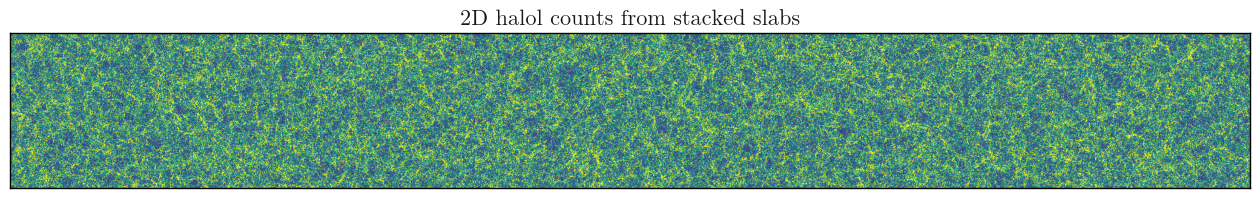

In [13]:
fig, ax = plt.subplots(figsize = (16, 10))
plt.imshow(binned_slabs[0].N_halos_2D, cmap='viridis', origin='lower', vmin=-1, vmax=5)
plt.xticks([])
plt.yticks([])
plt.title('2D halol counts from stacked slabs', fontsize=16)
fig.savefig(rf'{figs_dir}/N_halos_2D_stacked_slabs_{M_range}.png', bbox_inches='tight', dpi=300)
# plt.colorbar(label='N_halos_2D', location  = 'bottom', aspect = 60)

In [14]:
def find_binned_counts(binned_model):
    delta_m_2D_bin_centers = binned_model.delta_m_2D_bin_mean
    Nh_counts = binned_model.N_halos_2D_bin_mean
    return delta_m_2D_bin_centers, Nh_counts

def find_turn_on_point(binned_model, N_th = 0.01):
    delta_m_2D, Nh = find_binned_counts(binned_model)
    mask = np.where(Nh >= N_th)
    Nh_masked = Nh[mask]
    delta_m_2D_masked = delta_m_2D[mask]
    return delta_m_2D_masked, Nh_masked 


def plot_masked_model(binned_model):
    delta_m, Nh = find_binned_counts(binned_model)
    delta_m_masked, Nh_maked = find_turn_on_point(binned_model)

    fig, ax = plt.subplots(1, 1, sharex=False, figsize = (12, 3))
    ax.plot(delta_m, Nh, color = "blue", marker = "+", label = "full range")
    ax.plot(delta_m_masked, Nh_maked, ls = "dashed",color = "red", marker = "o", ms = 3,label = "masked range")

    ax.set_xlabel(r"$\delta_{m}^{2D}$", fontsize = 14)
    ax.set_ylabel(r"$N_{h}^{2D}$", fontsize= 14)

    ax.axvline(delta_m_masked[0], ls = "dashed", color = "black", label = "turn-on threshold")

    ax.set_title(rf"{np.log10(binned_model.Mh_min):.2f}< $log10(M_{{halos}})$ < {np.log10(binned_model.Mh_max):.2f}, $\delta_{{t}}$ = {delta_m_masked[0]:.2f}")


    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    return fig, ax

In [15]:
# preparing the bias model for inference
fixed_params_names = ["theta1", "theta2"]
fixed_params_values = [0, 0]
free_params_names = ["m1", "p1", "m2", "p2"]
bias_model = BiasModel.double_linear_bias_model()
theta_model = ThetaModel.linear_theta_model()

Text(0, 0.5, '$\\delta_{m}^{2D}$')

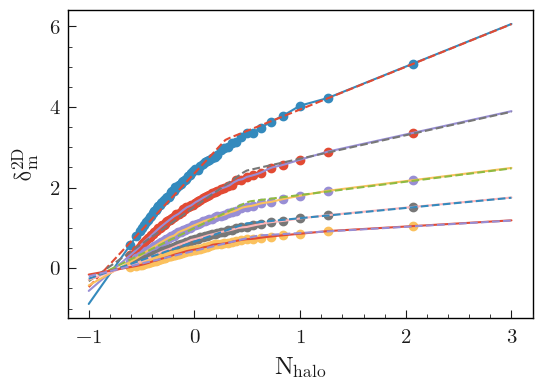

In [16]:
initial_guesses = []
delta_m_bins_list = []
covariances = []

x = []
y = []
for i, model in enumerate(binned_slabs, 0):
    delta_m, _ = find_turn_on_point(model)
    splined_bias_model = model.interpolated_bias_function(ncells = 2*4096, delta_m_cut = delta_m[0])
    delta_m_2D_sample = np.linspace(-1, 3, 100)
    popt, pcov = model.fit_bias_model_to_spline(initial_guess=(1, 0, 0.5, 1) , bias_model=bias_model, bias_relation_splined=splined_bias_model)
    initial_guesses.append(popt)
    covariances.append(np.diagonal(pcov))
    plt.plot(delta_m_2D_sample, splined_bias_model(delta_m_2D_sample))
    plt.plot(delta_m_2D_sample, bias_model.function(delta_m_2D_sample, m1 = popt[0], p1 = popt[1], m2 = popt[2], p2 = popt[3]), ls = "dashed")
    plt.scatter(model.delta_m_2D_bin_mean , model.N_halos_2D_bin_mean)
plt.xlabel(r'$N_{halo}$')
plt.ylabel(r'$\delta_{m}^{2D}$')

In [17]:
# split the simulation into halo mass bins
model1 = []
likelihood= []
delta_m_bins_list = []
for i, (stacked_slabs, Mh_min, Mh_max, initial_guess) in enumerate(zip(binned_slabs, M_halo_bin_edges[:-1], M_halo_bin_edges[1:], initial_guesses), 0):
    delta, _ = find_turn_on_point(stacked_slabs, N_th=0.05)
    
    popt, pcov, L = stacked_slabs.optimize_max_L_Poissonian(initial_guess=initial_guess, fixed_params_names=fixed_params_names, 
                                                            fixed_params_values = fixed_params_values, free_params_names=free_params_names, 
                                                            bias_model=bias_model, delta_m_cut = delta[0])

    
    model_binned = ModelComparison(slab_object=stacked_slabs, 
                                   bias_model=bias_model, theta_model=theta_model, parameters_names=free_params_names + fixed_params_names,
                                   parameters_values=list(popt) + fixed_params_values,
                                   Mh_min=Mh_min, Mh_max=Mh_max, delta_m_cut=delta[0])
    model1.append(model_binned)
    likelihood.append(L)

/opt/anaconda3/envs/Bias/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [18]:
from scipy.interpolate import interp1d

def plot_fits(self, nh_HOD, delta_HOD, color = "red", marker = None):
        delta_m_2D_bin_centers = self.delta_m_2D_bin_mean
        N_halos_2D_model = self.bias_model.function(delta_m_2D_bin_centers, **self.parameters)
         
        fig, (ax_counts, ax_err) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=False, figsize = (10, 5))
        
        
        
        
        mask = (delta_m_2D_bin_centers > self.delta_m_cut)    
      
      
        
        ax_counts.errorbar(delta_m_2D_bin_centers, self.N_halos_2D_bin_mean, yerr = self.N_halos_2D_bin_error,
                          marker = "o", ms = 3, color = "black", label = "binned halo counts", ls = 'dashed')
        ax_counts.plot(delta_m_2D_bin_centers[mask], N_halos_2D_model[mask], ls = "dashed", marker = marker, color = color, label = self.bias_model.name + " fit")
        

       

        ax_counts.plot(delta_HOD, nh_HOD, color = "blue", ls = "-.", label = "Shechter function expectation")
        
          
        # Get the current x axis limits
        x_min, x_max = ax_counts.get_xlim()
        
        # Make sure x_min is actually the minimum value by taking the minimum of the current xlim and data
        x_min = min(x_min, min(delta_m_2D_bin_centers))
        
        # Ensure the x_min is well below the minimum of your data points 
        # (giving a bit of extra space to ensure no white space at the edge)
        x_min = x_min - 0.05 * abs(x_max - x_min) 
        
        # Set the updated limits
        ax_counts.set_xlim(x_min, x_max)
        # Now apply the shading from the updated x_min to delta_m_cut
        ax_counts.axvspan(x_min, self.delta_m_cut, alpha=0.3, color='black', label='No halos region')

        ax_counts.set_ylabel(r"$N_{h}$", fontsize = 14)
        ax_counts.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        ax_counts.set_title(rf"{np.log10(self.Mh_min):.2f}< $log10(M_{{halos}})$ < {np.log10(self.Mh_max):.2f}")
                
        
        # ax_stoch.errorbar(delta_m_2D_bin_centers, quantities["simulation"], yerr = quantities_errors["simulation"], 
        #             marker = "o", color= "black", label = "Simulation")
    
    
        
        ax_counts.set_xlabel(r"$\delta_{m}^{2D}$", fontsize = 14)
        
        
        Nh_HOD_interp = interp1d(x = delta_HOD, y = nh_HOD,fill_value="extrapolate")
        Nh_sim_interp = interp1d(x = self.delta_m_2D_bin_mean, y = self.N_halos_2D_bin_mean, fill_value="extrapolate")
        Nh_model_interp = interp1d(x = delta_m_2D_bin_centers[mask], y = N_halos_2D_model[mask], fill_value='extrapolate')
        
        ax_err.plot(delta_HOD, (Nh_sim_interp(delta_HOD)/Nh_HOD_interp(delta_HOD)) - 1, label = r'$N^{sim}/N^{CM} - 1$', color = 'blue')
        ax_err.plot(delta_HOD, (Nh_sim_interp(delta_HOD)/Nh_model_interp(delta_HOD)) - 1, label = r'$N^{sim}/N^{model} - 1$', color = 'red')
        ax_err.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        
        ax_err.axhline(0, ls = 'dashed', color = 'black')
        
        ax_err.set_ylim(-0.1, 0.1)
        ax_err.set_xlabel(r"$\delta_{m}^{2D}$", fontsize = 14)
        
        return  ax_counts, ax_err, fig

In [19]:
nh_list_avg= np.load(f"{data_dir}/nh_list_{M_range}.npy")

delta_m = np.linspace(-1, 2.5, 100)

Halo Mass Bin 0


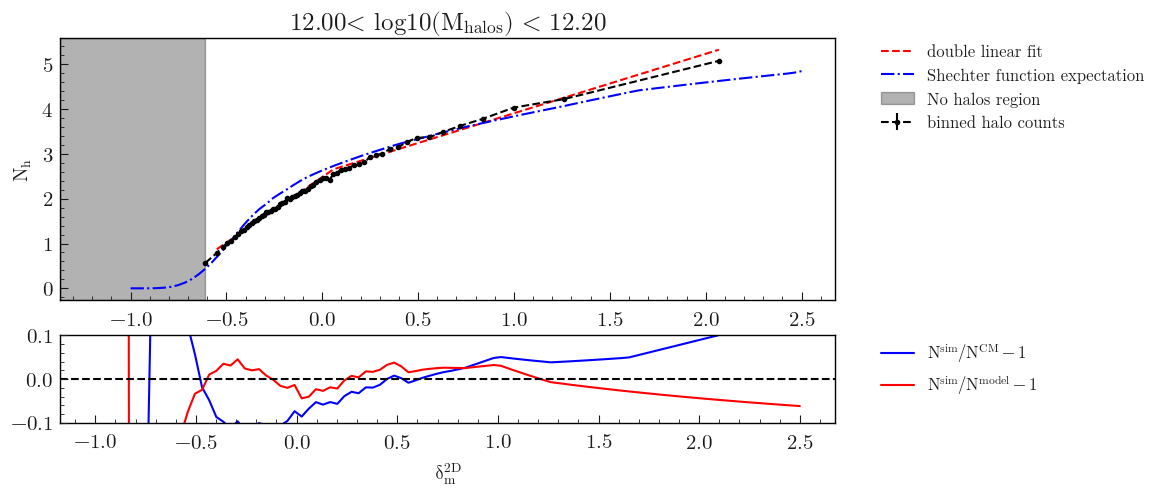

Halo Mass Bin 1


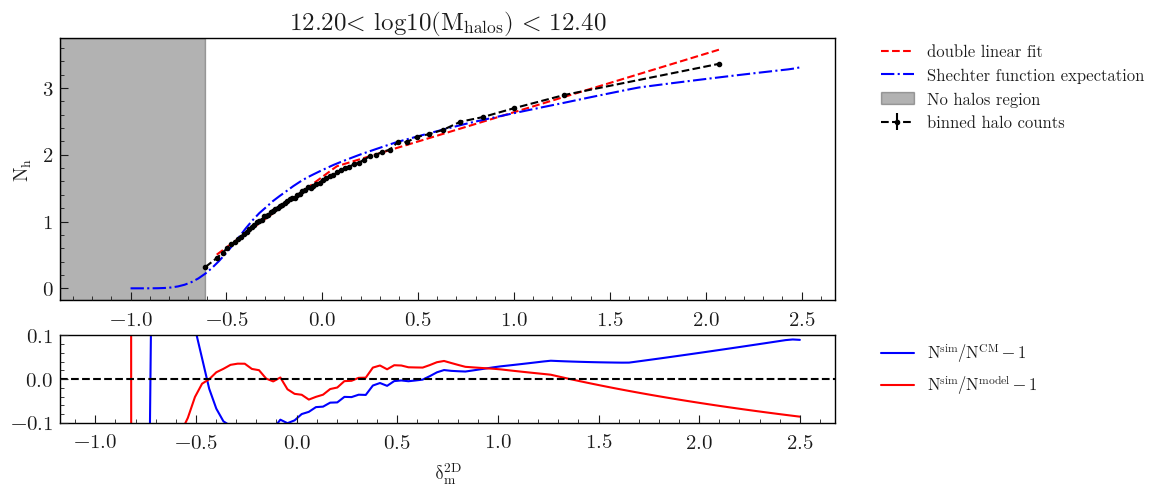

Halo Mass Bin 2


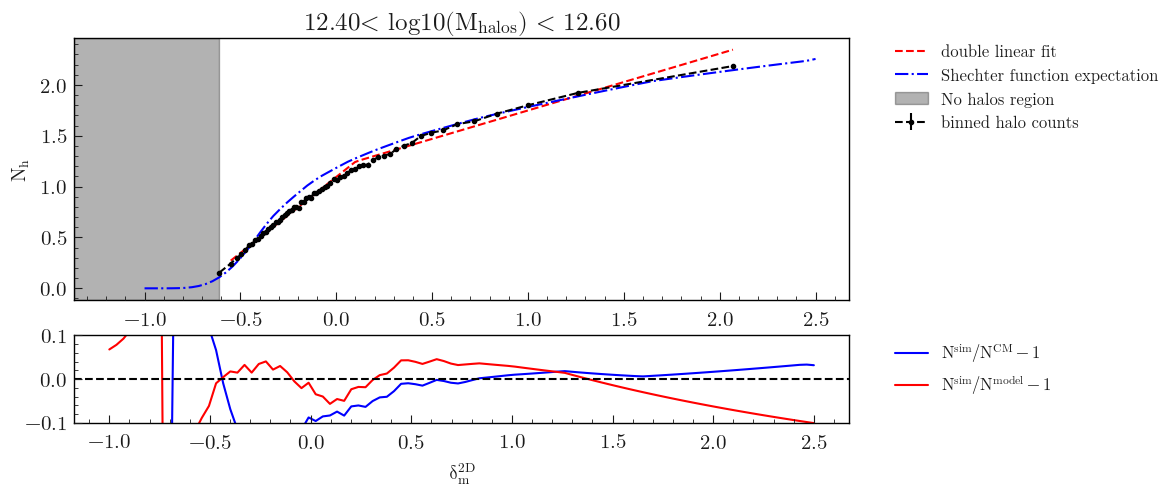

Halo Mass Bin 3


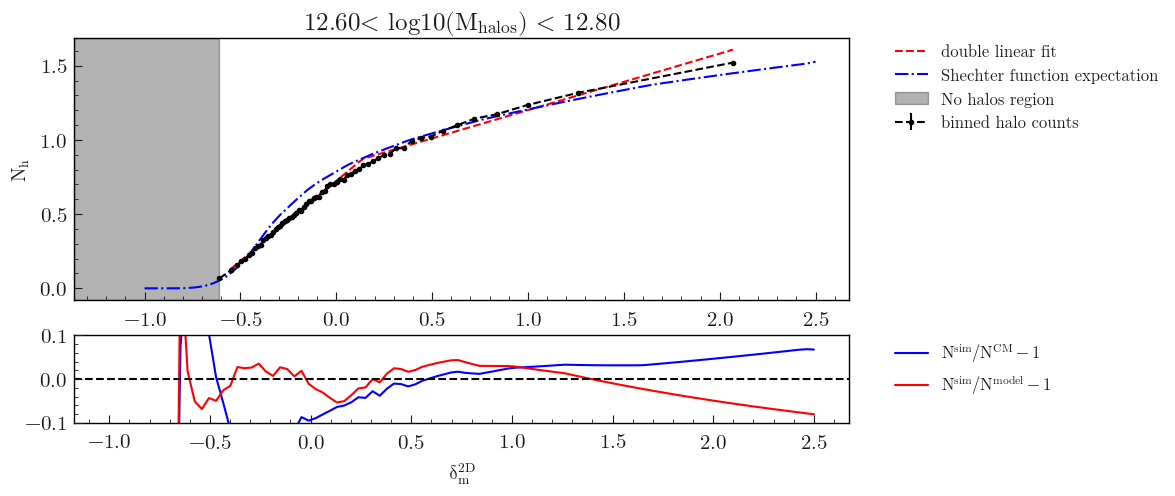

Halo Mass Bin 4


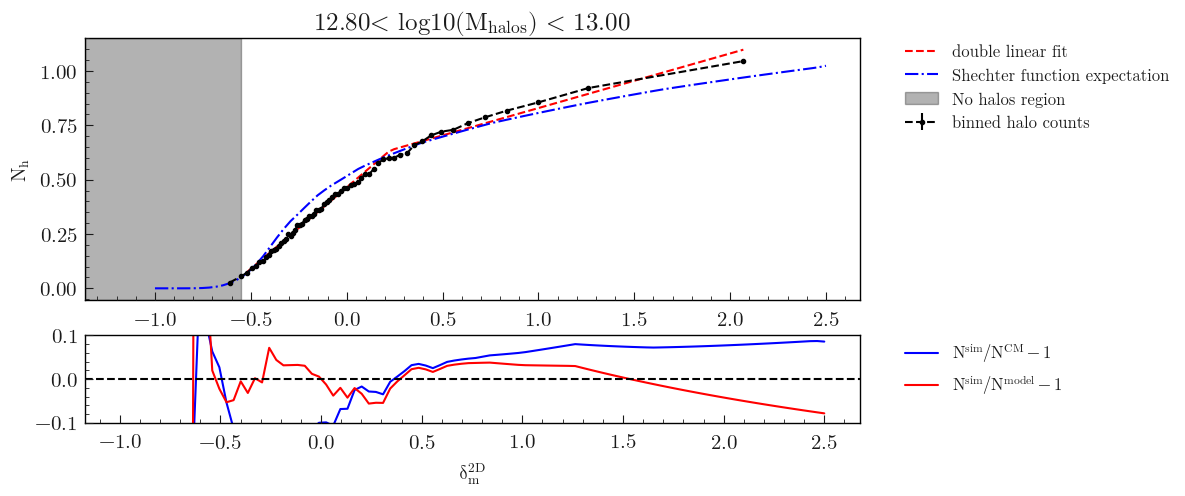

In [20]:
for i, bias1 in enumerate(model1, 0):
    print("Halo Mass Bin", i)
    ax_counts, ax_err, fig = plot_fits(bias1,  nh_HOD= nh_list_avg[i], delta_HOD=delta_m , marker = None)
    # ax_counts.fill_between(delta_m, nh_list_lower[i], nh_list_higher[i], color = "blue", alpha = 0.3, label = "Shechter function uncertainty")
    ax_counts.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    print("===================")
    print("===================")
    
    fig.savefig(rf"{figs_dir}/bin{i}_{M_range}].png",bbox_inches='tight')
    plt.show()

 


Finding the turn-on points of halo formation in each bin

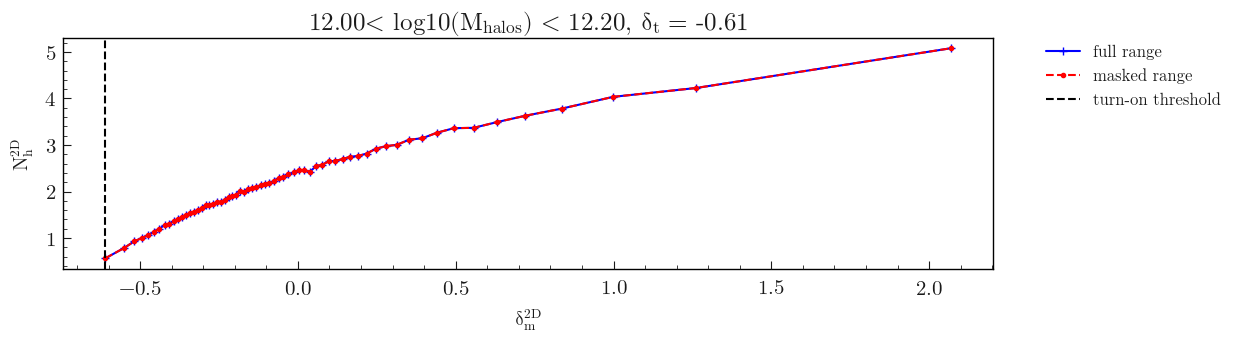

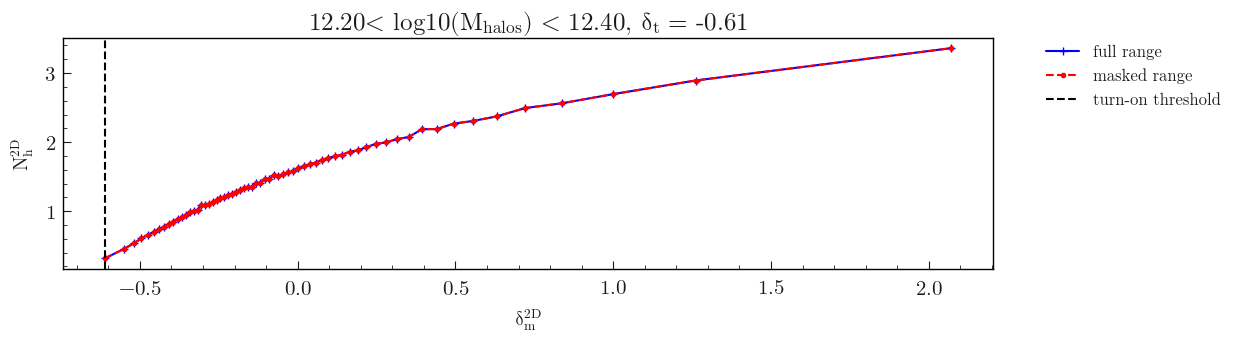

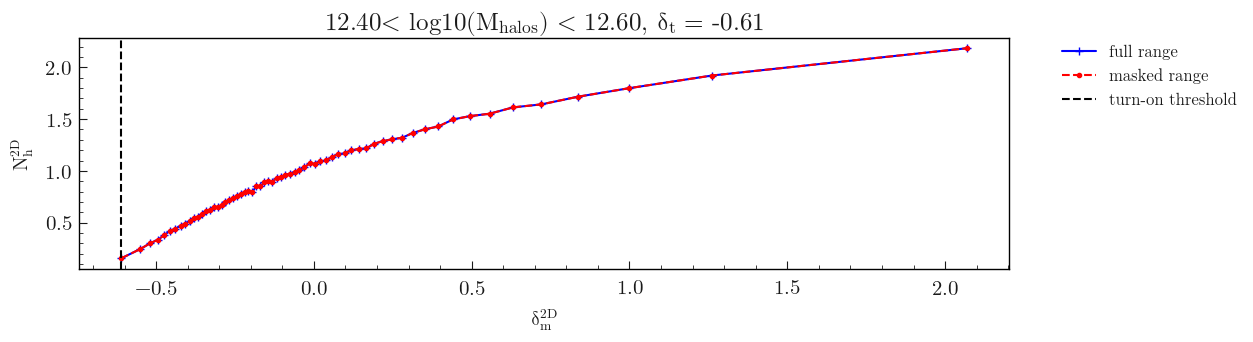

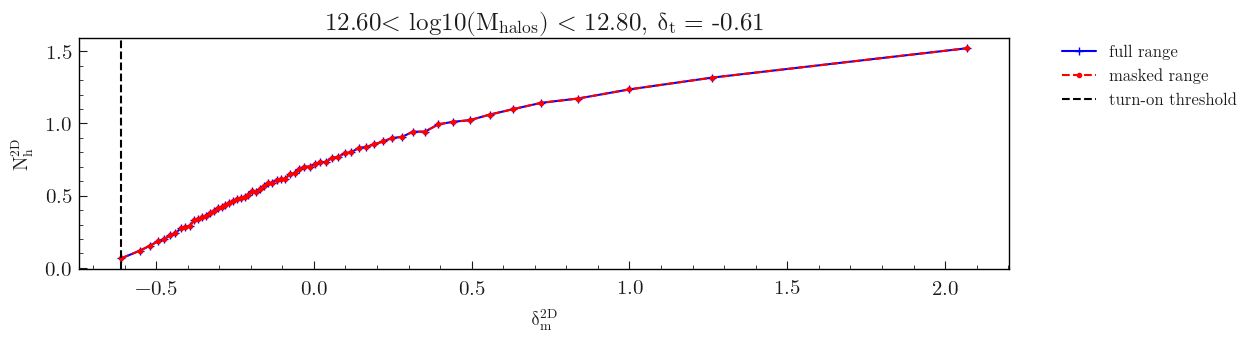

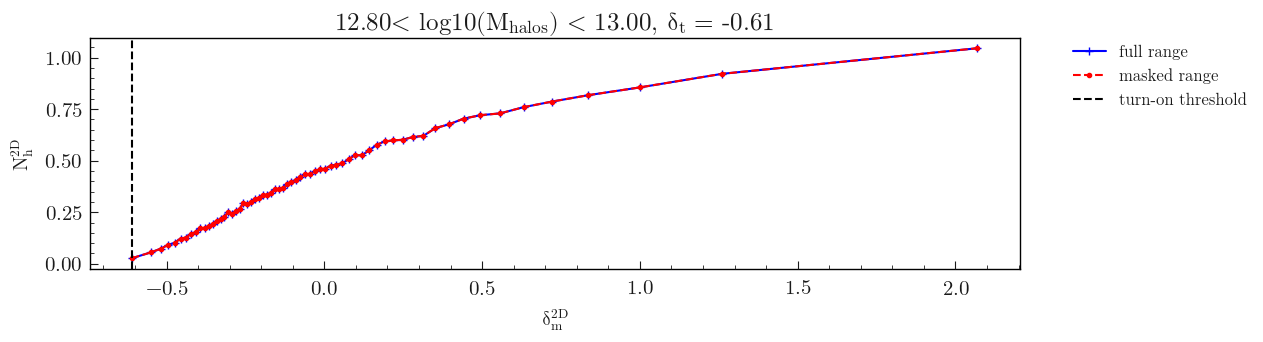

In [21]:
for i, bias in enumerate(model1, 0):
    fig, ax = plot_masked_model(bias)
    print("===================")
    print("===================")
    plt.show()

Plotting each of the parameters against the halo mass bin. Also, I plot the transition point from one linear function to another.

In [22]:
a1_list = []
b1_list = []
a2_list = []
b2_list = []
delta_t2_list = []
n_bar = []


for i in model1:
    A = i.slab_object.find_A()
    n_bar.append(A)
    a1_list.append(i.parameters["m1"]/A)
    b1_list.append(i.parameters["p1"]/A)
    a2_list.append(i.parameters["m2"]/A)
    b2_list.append(i.parameters["p2"]/A)
    delta_t2_list.append((b2_list[-1] - b1_list[-1])/(a1_list[-1] - a2_list[-1]))   

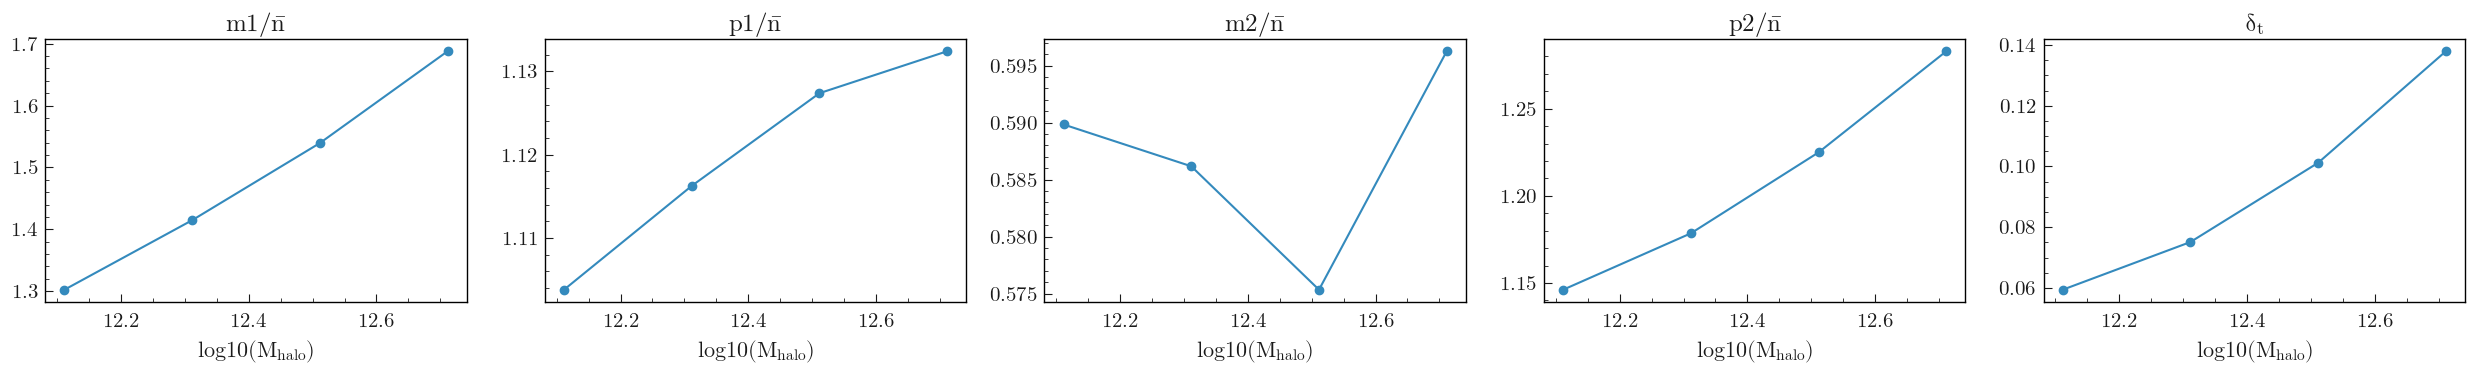

In [23]:
fig, (ax_a1, ax_b1, ax_a2, ax_b2, ax_delta_t2) = plt.subplots(1, 5, figsize = (25, 4))
k = 1
ax_a1.plot(np.log10(M_halo_bin_center)[:-k], a1_list[:-k], marker = "o")
ax_b1.plot(np.log10(M_halo_bin_center)[:-k], b1_list[:-k], marker = "o")
ax_a2.plot(np.log10(M_halo_bin_center)[:-k], a2_list[:-k], marker = "o")
ax_b2.plot(np.log10(M_halo_bin_center)[:-k], b2_list[:-k], marker = "o")
ax_delta_t2.plot(np.log10(M_halo_bin_center)[:-k], delta_t2_list[:-k], marker = "o")

for i in [ax_a1, ax_b1, ax_a2, ax_b2, ax_delta_t2]:
    i.set_xlabel(r"$log10(M_{halo})$", fontsize = 16)
for i, j in zip([ax_a1, ax_b1, ax_a2, ax_b2], bias_model.parameters + [r"$\delta_t$"]):
    i.set_title(j + r"$/\bar{n}$")

ax_delta_t2.set_title(r"$\delta_t$")

plt.tight_layout()

